<a href="https://colab.research.google.com/github/jrudascas/security_project/blob/CCB/limpieza_CCB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)  
import matplotlib.ticker as ticker
import os
import plotly.express as px
from matplotlib.ticker import FuncFormatter

In [120]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
os.chdir("/content/drive/Shared drives/seguridad/seguridad/CCB/limpieza")

In [126]:
data=pd.read_csv("../datos/CCB 2017 - 2018.csv",delimiter="|")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (13,19) have mixed types. Specify dtype option on import or set low_memory=False.



In [127]:
# registros con valores anomalos
(data == '-').sum()

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



FECHA                  0     
ANIO                   0     
NUM_SEMESTRE           0     
COD_LOCALIDAD          0     
NOMBRE_LOCALIDAD       0     
COD_UPZ                0     
NOMBRE_UPZ             0     
COD_SCAT               0     
NOMBRE_SECTOR_CAT      0     
COD_BARRIO             0     
NOMBRE_BARRIO          0     
ESTRATO                1209  
ENCUESTA               595421
ID_ENCUESTADO          478   
PREGUNTA_N1            595421
NOMBRE_PREGUNTA_N1     595421
PREGUNTA_N2            595421
PREGUNTA_N3            595421
NOMBRE_PREGUNTA        595421
COD_RESPUESTA          613379
DESC_RESPUESTA         613379
FACTOR_EXPANSION       0     
NUM_LATITUD            0     
NUM_LONGITUD           0     
NUM_NUMERO_REGITROS    0     
dtype: int64

In [128]:
# Eliminar Columnas constantes
to_delete=[]
for i in data.columns:
  if len(data[i].unique()) == 1:
    to_delete.append(i)
print(to_delete)
data.drop(to_delete,axis=1,inplace=True)

['COD_UPZ', 'NOMBRE_UPZ', 'COD_SCAT', 'NOMBRE_SECTOR_CAT', 'COD_BARRIO', 'NOMBRE_BARRIO', 'NUM_LATITUD', 'NUM_LONGITUD']


In [129]:
# Inputacion estrato segun la mayoria en cada localidad basado en los datos 
NOMBRE_LOCALIDAD='NOMBRE_LOCALIDAD'
ESTRATO='ESTRATO'
FACTOR_EXPANSION='FACTOR_EXPANSION'

Estrato_localidad=data.groupby([NOMBRE_LOCALIDAD,ESTRATO]).agg({FACTOR_EXPANSION:'sum'}).reset_index()
Estrato_localidad=Estrato_localidad[Estrato_localidad[ESTRATO] != '-']
Estrato_localidad=Estrato_localidad.loc[list(Estrato_localidad.groupby(NOMBRE_LOCALIDAD).agg({FACTOR_EXPANSION: 'idxmax'})[FACTOR_EXPANSION].values)].drop(FACTOR_EXPANSION,axis=1)
print(Estrato_localidad)

missing_estrato=data[data.ESTRATO == '-'][[NOMBRE_LOCALIDAD,ESTRATO]]
index_missing_estrato=missing_estrato.index
data[ESTRATO].values[index_missing_estrato]=missing_estrato.merge(Estrato_localidad,on=NOMBRE_LOCALIDAD)[ESTRATO+'_y'].values

      NOMBRE_LOCALIDAD    ESTRATO
2   ANTONIO NARIÑO      ESTRATO 3
6   BARRIOS UNIDOS      ESTRATO 3
11  BOSA                ESTRATO 2
16  CANDELARIA          ESTRATO 2
22  CHAPINERO           ESTRATO 4
25  CIUDAD BOLIVAR      ESTRATO 1
30  ENGATIVA            ESTRATO 3
34  FONTIBON            ESTRATO 3
38  KENNEDY             ESTRATO 2
43  LOS MARTIRES        ESTRATO 3
48  PUENTE ARANDA       ESTRATO 3
52  RAFAEL URIBE URIBE  ESTRATO 2
56  SAN CRISTOBAL       ESTRATO 2
61  SANTA FE            ESTRATO 2
66  SUBA                ESTRATO 2
74  TEUSAQUILLO         ESTRATO 4
79  TUNJUELITO          ESTRATO 3
83  USAQUEN             ESTRATO 3
89  USME                ESTRATO 2


In [0]:
#Inputacion nombre encuesta segun periodo
FECHA='FECHA'
ENCUESTA='ENCUESTA'

FECHA_ENCUESTA={'01-JUN-17':'100-ENC-SEGURIDAD-BOG-JUNIO-2017',
               '01-DEC-17':'100-ENC-SEGURIDAD-BOG-DICIEMBRE-2017',
               '01-JUN-18':'100-ENC-SEGURIDAD-BOG-JUNIO-2018',
               '01-DEC-18':'100-ENC-SEGURIDAD-BOG-DICIEMBRE-2018'
              }
data[ENCUESTA] = [FECHA_ENCUESTA[i] for i in data[FECHA].values]

In [131]:
# Elimininacion registros sin informacion de preguntas ni respuestas
index_no_respuestas=data[(data.ID_ENCUESTADO == '-') & (data.PREGUNTA_N1 == '-') & (data.PREGUNTA_N2 == '-') & (data.PREGUNTA_N3 == '-') & (data.COD_RESPUESTA == '-') & (data.DESC_RESPUESTA == '-')].index
print(len(index_no_respuestas))
data.drop(index_no_respuestas,inplace=True)
data.reset_index(drop=True,inplace=True)
# Elimininacion registros sin informacion de respuestas
index_no_respuestas=data[(data.COD_RESPUESTA == '-') & (data.DESC_RESPUESTA == '-')].index
print(len(index_no_respuestas))
data.drop(index_no_respuestas,inplace=True)
data.reset_index(drop=True,inplace=True)

42
613337


In [0]:
# Identificamos encuestas con valores anomalos en ID_ENCUESTADO
FECHA='FECHA'
ID_ENCUESTADO='ID_ENCUESTADO'
FACTOR_EXPANSION='FACTOR_EXPANSION'

for date in data[FECHA].unique():
  T=data[data[FECHA] == date]
  top=T[T[ID_ENCUESTADO] != '-'][ID_ENCUESTADO].astype(int).max()
  Factors=T[T[ID_ENCUESTADO] == '-'][FACTOR_EXPANSION].unique()
  for i,f in enumerate(Factors,1):
    data[ID_ENCUESTADO].values[T[(T[FACTOR_EXPANSION] == Factors[0]) & (T[ID_ENCUESTADO] == '-')].index]=top+i
    
# identificar id_encuestado de manera unica por periodo
data[ID_ENCUESTADO]=data[ID_ENCUESTADO].astype(str)+"-"+(pd.factorize(data[FECHA])[0]+1).astype(str)
data.reset_index(drop=True,inplace=True)

In [133]:
# registros con valores anomalos
(data == '-').sum()

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



FECHA                  0
ANIO                   0
NUM_SEMESTRE           0
COD_LOCALIDAD          0
NOMBRE_LOCALIDAD       0
ESTRATO                0
ENCUESTA               0
ID_ENCUESTADO          0
PREGUNTA_N1            0
NOMBRE_PREGUNTA_N1     0
PREGUNTA_N2            0
PREGUNTA_N3            0
NOMBRE_PREGUNTA        0
COD_RESPUESTA          0
DESC_RESPUESTA         0
FACTOR_EXPANSION       0
NUM_NUMERO_REGITROS    0
dtype: int64

In [0]:
#Eliminar registros repetidos 
data.drop_duplicates(inplace=True)

In [135]:
# verificamos que la cantidad de encuestados en cada periodo coincide con la real
data.groupby('FECHA').agg({'ID_ENCUESTADO':'nunique'})

,ID_ENCUESTADO
FECHA,
01-DEC-17,8589
01-DEC-18,10498
01-JUN-17,8749
01-JUN-18,8191


In [0]:
# Eliminamos informacion anterior numero de encuestas por periodo
data.drop('NUM_NUMERO_REGITROS',axis=1,inplace=True)

In [0]:
#guardamos nueva version del dataset sin entradas repetidas ni celdas vacias
#data.to_csv("resultado/CCB 2017 - 2018_no_null.csv",index=False)
data=pd.read_csv("resultado/CCB 2017 - 2018_no_null.csv")

In [138]:
# EL factor de expansion es unico para cada encuestado
print(len(data[['ID_ENCUESTADO','FACTOR_EXPANSION']].drop_duplicates()))
print(len(data.ID_ENCUESTADO.unique()))

36027
36027


In [0]:
#Identificamos las preguntas y creamos la base que conforma el nuevo dataset
Preguntas=sorted(data.PREGUNTA_N3.unique())
cols_fixed=['FECHA','ANIO','NUM_SEMESTRE','COD_LOCALIDAD','NOMBRE_LOCALIDAD','ESTRATO','ENCUESTA','ID_ENCUESTADO','FACTOR_EXPANSION']
X=data[cols_fixed].drop_duplicates()

In [0]:
# adicionamos las respuestas a cada pregunta como una columna
for pregunta in Preguntas:
  X=X.merge(data[data.PREGUNTA_N3 == pregunta][['ID_ENCUESTADO','COD_RESPUESTA']].rename(columns={'COD_RESPUESTA':pregunta}),
            on='ID_ENCUESTADO',how='left').fillna(0)
  X[pregunta]=X[pregunta].astype(int)

In [141]:
#X.to_csv("resultado/CCB_1_row_1_entrevista.csv",index=False)
X

,FECHA,ANIO,NUM_SEMESTRE,COD_LOCALIDAD,NOMBRE_LOCALIDAD,ESTRATO,ENCUESTA,ID_ENCUESTADO,FACTOR_EXPANSION,P102,P103,P104,P106,P107_1,P107_12,P107_13,P107_14,P107_2,P107_2.1,P107_3,P107_3.1,P107_4,P107_5,P107_5.1,P107_6,P107_6.1,P107_7,P107_8,P107_9,P107_99,P108.1,P108.10,P108.11,P108.2,P108.3,P108.4,P108.5,P108.6,P108.7,P108.8,P109,P110.1,P110.2,P111,P112,P113,P114_10,P114_11,P114_12,P114_13,P114_2,P114_3,P114_4,P114_5,P114_6,P114_7,P114_8,P114_9,P115,P116_2,P116_3,P116_4,P116_5,P116_6,P117,P121,P121.A_1,P121.A_2,P121.A_3,P121.A_4,P121.A_5,P121.A_99,P121.B_1,P121.B_2,P121.B_3,P121.B_97,P121.B_99,P122,P128,P201,P202,P203,P204.1,P204.1.1,P204.1.10,P204.1.17,P204.1.2,P204.1.3,P204.1.4,P204.1.5,P204.1.6,P204.1.7,P204.1.8,P204.1.9,P204.1.97,P204.1.99,P204.10,P204.13,P204.18,P204.19,P204.2,P204.20,P204.21,P204.22,P204.23,P204.24,P204.25,P204.26,P204.27,P204.28,P204.29,P204.3,P204.4,P204.4.1,P204.4.2,P204.5,P204.5.1,P204.5.2,P204.5.3,P204.5.4,P204.5.5,P204.6,P204.7,P206,P207,P208.1,P208.12,P208.14,P208.2,P208.3,P208.4,P208.7,P208.99,P210.1,P210.10,P210.11,P210.12,P210.13,P210.14,P210.15,P210.18,P210.19,P210.2,P210.3,P210.4,P210.5,P210.6,P210.7,P210.8,P210.9,P210.98,P210.99,P213,P214,P215_1,P215_2,P215_3,P215_4,P215_5,P215_6,P215_7,P215_8,P215_99,P216_1,P216_2,P216_3,P216_4,P216_5,P216_6,P216_7,P216_8,P216_99,P220,P221,P223.1,P223.2,P223.3,P223.4,P223.5,P223.6,P223.7,P223.8,P224,P225.1,P225.2,P225.3,P225.4,P225.5,P225.6,P225.7,P225.8,P225.9,P225.99,P230,P230.1,P232_1,P232_1.1,P232_1.11,P232_1.2,P232_1.3,P232_1.4,P232_1.5,P232_1.6,P232_1.7,P232_1.9,P232_1.97,P232_1.99,P232_10,P232_11,P232_12,P232_13,P232_14,P232_15,P232_16,P232_17,P232_18,P232_19,P232_2,P232_20,P232_22,P232_23,P232_24,P232_3,P232_4,P232_4.1,P232_4.2,P232_5,P232_5.1,P232_5.2,P232_6,P232_7,P232_9,P233,P234_1,P234_11,P234_12,P234_14,P234_15,P234_16,P234_17,P234_18,P234_19,P234_2,P234_20,P234_21,P234_22,P234_23,P234_24,P234_25,P234_26,P234_27,P234_28,P234_29,P234_3,P234_4,P234_5,P234_6,P234_9,P234_99,P235,P235.1_1,P235.1_2,P235.1_3,P235.1_4,P235.1_5,P235.1_6,P235.1_7,P235.1_8,P235.1_9,P235.1_99,P236,P237,P238.1,P238.13,P238.18,P238.19,P238.2,P238.20,P238.21,P238.22,P238.23,P238.25,P238.26,P238.27,P238.28,P238.29,P238.3,P238.4,P238.6,P239_1,P239_2,P239_3,P239_4,P239_5,P239_6,P239_99,P240.1,P240.10,P240.11,P240.12,P240.13,P240.14,P240.2,P240.3,P240.4,P240.5,P240.6,P240.7,P240.8,P240.9,P240.99,P241,P3,P301.1,P301.10,P301.11,P301.12,P301.2,P301.3,P301.4,P301.5,P301.6,P301.7,P301.8,P301.9,P302.1,P302.10,P302.2,P302.3,P302.4,P302.5,P302.6,P302.7,P302.8,P302.9,P303.1,P303.10,P303.11,P303.12,P303.3,P303.5,P303.6,P303.7,P303.8,P303.9,P304.1,P304.10,P304.11,P304.12,P304.3,P304.4,P304.5,P304.7,P304.8,P304.9,P305,P307_1,P307_2,P307_3,P307_4,P307_5,P307_6,P308,P309_1,P309_2,P309_3,P309_4,P309_5,P309_99,P310_1,P310_10,P310_11,P310_12,P310_13,P310_2,P310_3,P310_4,P310_5,P310_6,P310_7,P310_8,P310_9,P312,P313,P313.1.1,P313.1.2,P313.1.3,P313.1.4,P313.1.5,P313.1.6,P314_1,P314_2,P314_3,P314_4,P314_5,P314_6,P314_7,P401,P403,P404.1,P404.10,P404.11,P404.13,P404.2,P404.3,P404.4,P404.5,P404.6,P404.7,P404.9,P405,P405.A_1,P405.A_2,P405.A_3,P405.A_4,P405.A_5,P405.A_6,P405.A_7,P405.A_97,P405.A_99,P407.1,P407.2,P407.3,P408.1,P408.2,P408.3,P408.4,P408.5,P408.6,P408.7,P409,P411,P412_1,P412_2,P412_3,P412_98,P412_99,P413.1,P413.10,P413.2,P413.3,P413.4,P413.5,P413.6,P413.7,P413.8,P413.9,P414.1,P414.2,P414.3,P414.4,P415,P416.1,P416.2,P416.3,P416.4,P416.5,P416.6,P416.7,P416.8,P416.9,P417,P419,P420,P421,P444,P445_1,P445_2,P445_3,P445_4,P445_5,P445_6,P445_7,P445_97,P445_99,P6,P702.A,P702_1,P702_10,P702_11,P702_12,P702_13,P702_14,P702_2,P702_3,P702_4,P702_5,P702_6,P702_7,P702_8,P702_9,P703_1,P703_2,P703_3,P703_4,P703_5,P703_6,P704_1,P704_2,P704_3,P704_4,P705_1,P705_2,P705_3,P705_4,P705_5,P706_1,P706_2,P706_3,P706_4,P706_5,P707_1,P707_2,P707_3,P707_4,P707_5,P708_1,P708_2,P708_3,P708_4,P708_5,P709_1,P709_2,P709_3,P709_4,P710_1,P710_2,P710_3,P710_4,P710_5,P711_1,P711_2,P711_3,P711_4,P711_5,P711_6,P712_1,P712_2,P712_3

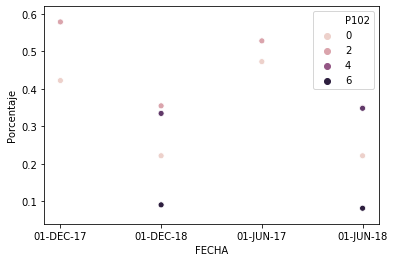

In [142]:
A=X.groupby(['FECHA','P102']).agg({'FACTOR_EXPANSION':'sum'}).reset_index()
A=A.merge(A.groupby('FECHA').agg({'FACTOR_EXPANSION':'sum'}),on=['FECHA'])
A['Porcentaje']=A['FACTOR_EXPANSION_x']/A['FACTOR_EXPANSION_y']
sns.scatterplot(data=A[['FECHA','P102','Porcentaje']],x='FECHA',y='Porcentaje',hue='P102')

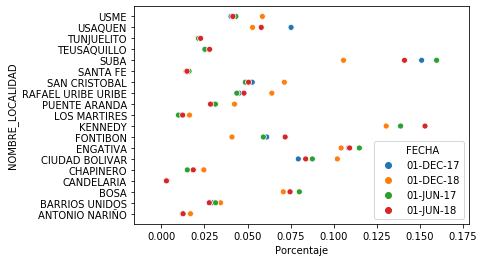

In [143]:
A=X.groupby(['FECHA','NOMBRE_LOCALIDAD']).agg({'FACTOR_EXPANSION':'sum'}).reset_index()
A=A.merge(A.groupby('FECHA').agg({'FACTOR_EXPANSION':'sum'}),on=['FECHA'])
A['Porcentaje']=A['FACTOR_EXPANSION_x']/A['FACTOR_EXPANSION_y']
sns.scatterplot(data=A[['FECHA','NOMBRE_LOCALIDAD','Porcentaje']],hue='FECHA',x='Porcentaje',y='NOMBRE_LOCALIDAD')